In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [ ]:
path = os.path.normpath(os.getcwd() + os.sep + os.pardir)
summerFlexPath = os.path.join(path, 'Data', 'Flexibility', 'Summer User Full')

In [3]:
# Reads the price data, data was obtained through ERCOT website, it is the RTM LMP data

price = pd.read_csv(os.path.join(path, 'Data', 'Price', 'price.csv'), index_col='time')
price.index = pd.to_datetime(price.index)

In [4]:
# Reads the weather data and upsample from 30-minute interval to 15-minute interval by linear interpolation

weather = pd.DataFrame()
for file in os.listdir(os.path.join(path, 'Data', 'Weather', 'Houston')):
    temp = pd.read_csv(os.path.join(path, 'Data', 'Weather', 'Houston', file))
    temp.index = pd.to_datetime(temp[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    temp = temp.iloc[:, 5:]
    
    weather = pd.concat((weather, temp))
    
weather = weather[['Wind Speed', 'Relative Humidity', 'Temperature']]
weather = weather.resample('15T').interpolate()

In [5]:
# Here, we will use the temperature's 75% & 50% percentile as thresholds for label creation

weather.loc[(weather.index >= datetime(2017, 6, 10)) & (weather.index <= datetime(2017, 8, 26)) & \
            (weather.index.hour >= 15) & (weather.index.hour <= 19)].describe()

,Wind Speed,Relative Humidity,Temperature
count,1540.000000,1540.000000,1540.000000
mean,2.019448,72.954338,29.543831
std,0.797484,14.241159,2.439095
min,0.300000,38.940000,24.000000
25%,1.450000,61.650000,27.500000
50%,2.000000,73.180000,29.500000
75%,2.500000,84.602500,31.500000
max,5.600000,100.000000,37.000000


This section reads in the flexibility data and goes through it day by day along with price and weather data. It calculates the flexibility by comparing the peak-hour time period to the non-peak time period and see if the difference is greater than 0.4.

For price, $40/MWh was set as the threshold and for weather, temperature's 75% & 50% percentile points are used as thresholds.

After stepping through each day in each user's flexibility file (remember each column is an individual day with the header being the date and there are totally 24 time steps.), the labels are concatenated at the end for cGAN. 

In [24]:
for file in os.listdir(summerFlexPath):
    temp = pd.read_csv(os.path.join(summerFlexPath, file))
    dates = temp.columns
    
    flex_label = np.array([])
    temperature_label = np.array([])
    price_label = np.array([])
    
    for i in temp.columns:
        flex_avg = temp[i].iloc[15:20].copy()
        flex_avg = flex_avg.mean()
        
        other_avg = (temp[i].loc[0:15]).mean()
        
        delta = (other_avg - flex_avg)/other_avg
        
        if delta >= 0.4 and other_avg >= 1 and (np.count_nonzero(temp[i].iloc[15:20] < 1)) > 2:
            flex_label = np.append(flex_label, 2)
        # elif (delta < 0.3 and delta >= 0.01) and (np.count_nonzero(temp[i].iloc[15:20] < 1) < 2 and np.count_nonzero(temp[i].iloc[15:20] < 1) <= 1):
        elif (delta < 0.4 and delta >= 0.2) and other_avg >= 1 and (np.count_nonzero(temp[i].iloc[15:20] < 1)) > 1:
            flex_label = np.append(flex_label, 1)
        else:
            flex_label = np.append(flex_label, 0)
        
        price_dr_avg = price.loc[i][60:80]
        
        if (price_dr_avg.values >= 40).any():
            price_label = np.append(price_label, 2)
        else:
            price_label = np.append(price_label, 0)
        
        weather_temp = weather.loc[i].copy()
        temp_avg = weather_temp['Temperature'][60:80].copy()
        
        if temp_avg.mean() >= 31.5:
           temperature_label = np.append(temperature_label, 2)
        elif temp_avg.mean() < 31.5 and temp_avg.mean() >= 29.5:
           temperature_label = np.append(temperature_label, 1)
        elif temp_avg.mean() < 29.5:
           temperature_label = np.append(temperature_label, 0)
    
    temp.loc[len(temp)] = flex_label
    temp.loc[len(temp)] = price_label
    temp.loc[len(temp)] = temperature_label
    
    temp.to_csv(os.path.join(path, 'Data', 'Flexibility', 'Summer with label', f'{file} label.csv'), index=False)

In [25]:
# This puts all flexibility profiles with the labels from all users into one file

flex_full = pd.DataFrame()

for file in os.listdir(os.path.join(path, 'Data', 'Flexibility', 'Summer with label')):
    temp = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Summer with label', file))
    for i in temp.columns:
        flex_full = pd.concat([flex_full, temp[i]], axis = 1)
        
flex_full.columns = range(flex_full.columns.size)
flex_full.to_csv(os.path.join(path, 'Data', 'Flexibility', 'Summer Full.csv'), index=False)

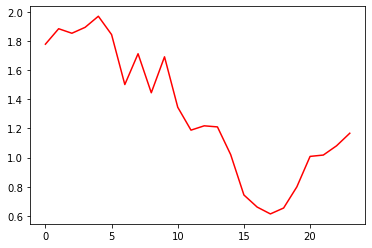

In [26]:
# This just plots the average flexibility profiles and verify the labelling.

flex = pd.DataFrame()

for i in flex_full.columns:
    temp = flex_full[i].copy()
    if temp.iloc[-3] == 2:
        flex = pd.concat([flex, temp], axis=1)

plt.plot(flex.iloc[:-3, :].mean(axis=1), c='red')